# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [20]:
# 1. Run only if you need to delete cached folder from Google Colab
!rm -rf /content/light-transport

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
# 2. Download the project files from Github
!git clone https://github.com/dipanjan92/light-transport.git

Cloning into 'light-transport'...


In [22]:
# 3. Add the project directory to the system PATH
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [23]:
# 4. PyVista is used to generate 3D objects
!pip install pyvista

In [24]:
# 5. Switch to project directory
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

*****************************************************************************

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box
from LightTransportSimulator.light_transport.src.constants import *

In [3]:
# load a 3D object using PyVista
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)

10

In [4]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

# set padding to be added around the object
padding = 5

# Compute depths of the Cornell box
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10

xmax, ymax, zmax, depth

(2.5, 2.0, 1.7320508, 7.5)

In [5]:
# Initialise an empty list for primitives
primitives = numba.typed.List()

In [6]:
from LightTransportSimulator.light_transport.src.cornell_box import get_floor

# Set wall colors and materials for the Cornell box
surface_color = WHITE_2
left_wall_color = RED
right_wall_color = GREEN
surface_mat = Material(color=surface_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)

# Get the triangles required to render the Cornell box
objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat)
# primitives = get_floor(x_depth, y_depth, z_depth, surface_mat)

In [ ]:
for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)

    triangle = PreComputedTriangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

In [7]:
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# Create a global light source

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5, emission=20)

# As conventional Cornell box has square light source (Area light),
# we will use two triangles to render the light source
light_1 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

light_2 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

# generate random samples on the light emitting surfaces
light_sources = generate_area_light_samples(tri_1=light_1,
                                          tri_2=light_2,
                                          source_mat=source_mat,
                                          number_of_samples=10,
                                          total_area=4)

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\intersects.py:26: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  b = 2 * np.dot(ray_direction, ray_origin - center)


In [8]:
# Add the light emitting triangles to the list of primitives
primitives.append(light_1)
primitives.append(light_2)

In [9]:
# Setup scene

# point camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

# screen
width=300
height=300

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=5
# number of samples per pixel
n_samples = 8

# Initialise the scene with lights and camera
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, f_distance=depth, number_of_samples=n_samples)

In [10]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(primitives)):
    bounded_boxes.append(BoundedBox(primitives[i], i))

len(primitives), len(bounded_boxes)

(18, 18)

In [11]:
# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
root, bounded_boxes, ordered_prims, total_nodes = build_bvh(primitives, bounded_boxes, start, end, ordered_prims, total_nodes)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [12]:
len(primitives) # number of primitives

18

In [13]:
total_nodes # total number of nodes in the bvh tree

17

In [14]:
# create a linear representation of the bvh tree
linear_nodes = numba.typed.List()
for _ in range(total_nodes):
    linear_nodes.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_nodes) # equals to the number of nodes in the original treei

17

In [15]:
# linear bvh
linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
len(linear_bvh)

17

In [16]:
# check if indexes of all primitives present in the linear bvh tree
total = 0
for _bvh in linear_bvh:
    total+= _bvh.n_primitives
total # should be equal to the number of primitives

18

In [17]:
from LightTransportSimulator.light_transport.src.path_tracing import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
image = render_scene(scene, primitives, linear_bvh)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\path_tracing.py:157: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'primitives' of function 'trace_path'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\src\path_tracing.py", line 17:
@numba.njit
def trace_path(scene, primitives, bvh, ray, bounce, rand):
^

  color += trace_path(scene, primitives, bvh, ray, 0, rand)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\path_tracing.py:157: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'primitives' of function 'cast_one_shadow_ray'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecat

0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.66666666666666670.6666666666666667

0.6666666666666667
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
2.0
2.02.0

2.0
2.0
2.0
2.0
2.0
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.3333333333333335
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
3.0
3.0
3.0
2.666666666666667
2.666666666666667
3.0
3.0
3.0


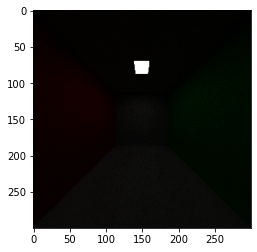

In [18]:
plt.imshow(image)